## Import

In [138]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler

## Data Load

In [139]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/data/train.csv'
test_path  = '/data/ephemeral/home/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [140]:
dt_test['계약년월'].unique()

array([202307, 202308, 202309])

In [141]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [142]:
dt_test.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일'],
      dtype='object')

In [143]:
# dt.iloc[1118821,:]
# dt_test.iloc[0,:]
# dt = pd.concat([dt,dt_test], axis = 0)
# dt.iloc[1118821,:]
# dt.iloc[1118822,:]

In [144]:
dt.dtypes.value_counts()

object     29
float64    18
int64       5
dtype: int64

In [145]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

## Drop columns

In [146]:
dt.drop(columns=['아파트명', '번지', '본번', '부번', '계약일', '도로명', '중개사소재지', 'k-전화번호','k-팩스번호',
                 '단지소개기존clob','k-전체동수','k-전체세대수','k-건설사(시공사)',
                 'k-시행사','k-연면적','k-주거전용면적','k-관리비부과면적','k-홈페이지','k-등록일자','k-수정일자','해제사유발생일','k-사용검사일-사용승인일',
                 '고용보험관리번호','건축면적','주차대수','단지승인일','사용허가여부','관리비 업로드','단지신청일','좌표X', '좌표Y'], inplace=True)
dt_test.drop(columns=['아파트명', '번지', '본번', '부번', '계약일', '도로명', '중개사소재지', 'k-전화번호','k-팩스번호',
                 '단지소개기존clob','k-전체동수','k-전체세대수','k-건설사(시공사)',
                 'k-시행사','k-연면적','k-주거전용면적','k-관리비부과면적','k-홈페이지','k-등록일자','k-수정일자','해제사유발생일','k-사용검사일-사용승인일',
                 '고용보험관리번호','건축면적','주차대수','단지승인일','사용허가여부','관리비 업로드','단지신청일','좌표X', '좌표Y'], inplace=True)

In [147]:
dt.columns

Index(['시군구', '전용면적(㎡)', '계약년월', '층', '건축년도', '등기신청일자', '거래유형',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4',
       'target'],
      dtype='object')

In [148]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in dt.columns:
    if pd.api.types.is_numeric_dtype(dt[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'target']
범주형 변수: ['시군구', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4']


# 결측치 처리


### 결측치가 있는 행 제거


In [149]:
missing_count = dt.isnull().sum(axis=1)
print(max(missing_count))

13


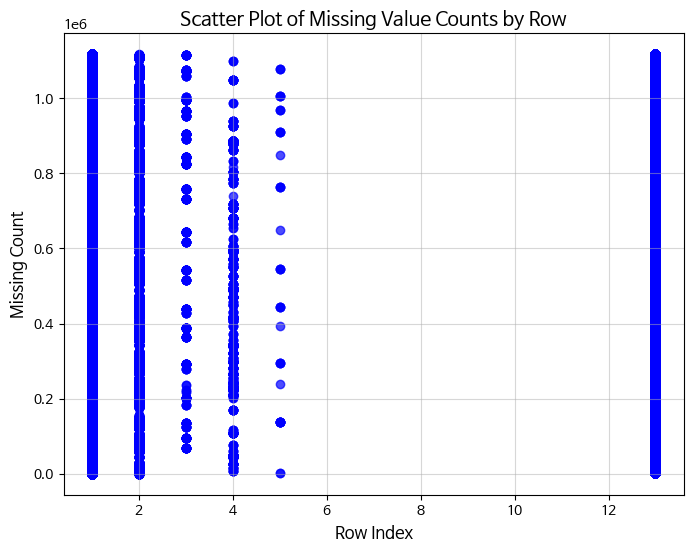

In [150]:
plt.figure(figsize=(8, 6))
plt.scatter(missing_count, range(len(missing_count)), color='blue', alpha=0.7)
plt.title('Scatter Plot of Missing Value Counts by Row', fontsize=14)
plt.xlabel('Row Index', fontsize=12)
plt.ylabel('Missing Count', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

In [151]:
threshold = 15  # 결측치 개수

# 각 행에 대해 결측치 개수를 계산하고, threshold 이상의 결측치를 가진 행을 삭제
dt = dt[dt.isnull().sum(axis=1) < threshold]
dt.shape

(1118822, 21)

In [152]:
dt.columns

Index(['시군구', '전용면적(㎡)', '계약년월', '층', '건축년도', '등기신청일자', '거래유형',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4',
       'target'],
      dtype='object')

## Train + Test Concat

In [153]:
dt = pd.concat([dt,dt_test], axis = 0).reset_index(drop=True) # test 데이터는 9272개 [-9272:]

In [154]:
dt.shape

(1128094, 21)

# 데이터 변환

### split 시군구


In [155]:
split_df = dt['시군구'].str.split(' ', expand=True)
split_df.columns = ['시', '구', '동'] 
split_df.drop(columns='시', inplace=True)
split_df.sample(20)

,구,동
1108302,성북구,정릉동
150059,강서구,염창동
84670,영등포구,양평동3가
350478,마포구,창전동
60285,서초구,양재동
870095,노원구,월계동
621134,송파구,방이동
584132,노원구,중계동
291093,중구,회현동2가
279622,성북구,정릉동


In [156]:
dt.drop(columns='시군구', inplace=True)
dt = pd.concat([dt, split_df], axis=1)
dt.columns

Index(['전용면적(㎡)', '계약년월', '층', '건축년도', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)',
       'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동'],
      dtype='object')

전용면적(㎡) : MinMax Scaling

계약년월 :연도, 월 분리 /  월 -> 성수기(6~8월 제외), 비수기(6~8월)로 구분

층 : Min max scaling

건축년도 : 2024년을 기준으로 차이값을 계산 후 이를 역수로 치환 (음수로 사용해볼수도 있음)

등기신청일자 : 있으면 1 없으면 0

거래유형 : (중개거래1, 직거래0)

## 계약년월 -> 연, 월 분할 / 월 -> 성수기 여부로 변환

In [157]:
dt['계약년도'] = dt['계약년월'].astype(str).str[:4].astype(int)
dt['계약월'] = dt['계약년월'].astype(str).str[4:6].astype(int)
dt.drop(columns=['계약년월'], inplace=True)
dt['성수기여부'] = dt['계약월'].apply(lambda x: 1 if 7 <= x <= 9 else 0) # 성수기 = 1, 비성수기 = 0
dt.drop(columns='계약월', inplace=True)
dt.columns

# maps = {'비성수기' : 0, '성수기' : 1}
# dt['성수기여부'] = dt['성수기여부'].map(maps)

Index(['전용면적(㎡)', '층', '건축년도', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)',
       'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부'],
      dtype='object')

## 전용면적, 층 MinMaxScaler()


In [158]:
scaler = MinMaxScaler()
dt['전용면적'] = scaler.fit_transform(dt[['전용면적(㎡)']])
scaler = MinMaxScaler()
dt['층'] = scaler.fit_transform(dt[['층']])
dt.drop(columns=['전용면적(㎡)'], inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적'],
      dtype='object')

In [159]:
dt.sample(5)

,층,건축년도,등기신청일자,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전용면적별세대현황(60㎡이하),...,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,target,구,동,계약년도,성수기여부,전용면적
622837,0.082192,1992,,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26500.0,송파구,오금동,2015,0,0.091383
1067078,0.273973,1994,,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,46800.0,영등포구,당산동2가,2008,0,0.175597
404060,0.095890,1996,,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56200.0,광진구,군자동,2018,0,0.180883
67970,0.246575,1999,,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,65000.0,성북구,삼선동4가,2018,1,0.253005
379293,0.191781,1998,,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,59800.0,영등포구,양평동2가,2019,0,0.119189


In [160]:
dt.isnull().sum()

층                               0
건축년도                            0
등기신청일자                          0
거래유형                            0
k-단지분류(아파트,주상복합등등)         877273
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전용면적별세대현황(60㎡이하)         876170
k-전용면적별세대현황(60㎡~85㎡이하)     876170
k-85㎡~135㎡이하               876170
k-135㎡초과                  1127765
경비비관리형태                    877561
세대전기계약방법                   885389
청소비관리형태                    877751
기타/의무/임대/임의=1/2/3/4        876125
target                       9272
구                               0
동                               0
계약년도                            0
성수기여부                           0
전용면적                            0
dtype: int64

## 건축년도 : 1 / (2024 - 건축년도)


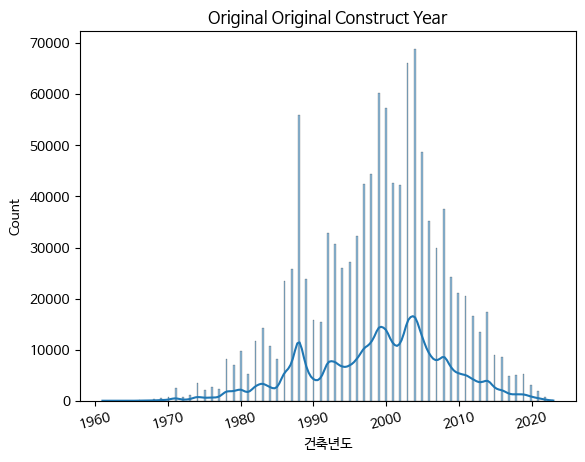

In [161]:
plt.title('Original Original Construct Year')
plt.xticks(rotation=15)
sns.histplot(dt['건축년도'], kde=True)
# plt.ylim(0, 2200)  
plt.show()

In [162]:
# 4. 건축년도 : 2024년 기준 차이값 계산 후 역수
dt['건축년도'] = 2024 - dt['건축년도']
# dt['건축년도'] = (1 / dt['건축년도']).round(2)
dt.columns

Index(['층', '건축년도', '등기신청일자', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적'],
      dtype='object')

In [163]:
# MinMaxScaler는 입력 데이터를 2D 형태([[value], ...] 또는 (n_samples, n_features))로 기대합니다.
# Pandas Series는 1D 배열 형태이므로 .values.reshape(-1, 1)로 변환해야 합니다
dt['건축년도'] = scaler.fit_transform(dt['건축년도'].values.reshape(-1, 1))
dt['건축년도']

0          0.580645
1          0.580645
2          0.580645
3          0.580645
4          0.580645
             ...   
1128089    0.145161
1128090    0.145161
1128091    0.145161
1128092    0.145161
1128093    0.145161
Name: 건축년도, Length: 1128094, dtype: float64

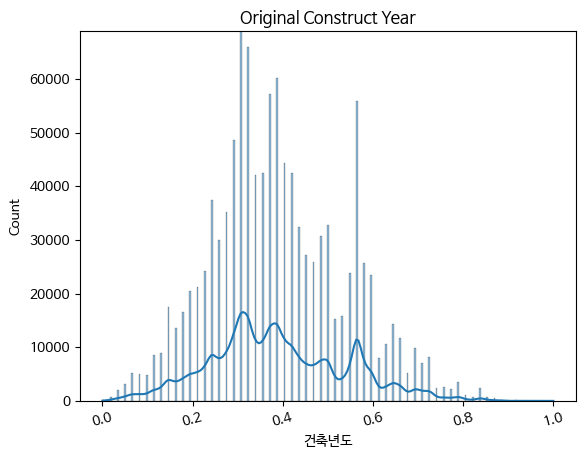

In [164]:
plt.title('Original Construct Year')
plt.xticks(rotation=15)
sns.histplot(dt['건축년도'], kde=True)
plt.ylim(0, dt['건축년도'].value_counts().max())  
plt.show()

## 중간점검


In [165]:
dt[['계약년도', '성수기여부', '전용면적', '층','건축년도']].sample(5)

,계약년도,성수기여부,전용면적,층,건축년도
386082,2020,1,0.144629,0.150685,0.145161
790184,2014,0,0.107458,0.123288,0.564516
340278,2020,1,0.171446,0.260274,0.258065
45507,2017,0,0.089935,0.150685,0.161290
1005161,2008,0,0.179604,0.150685,0.709677


In [166]:
dt[['계약년도', '성수기여부', '전용면적', '층','건축년도']].isnull().sum()

계약년도     0
성수기여부    0
전용면적     0
층        0
건축년도     0
dtype: int64

## 등기신청일자

등기신청일자 : 있으면 1 없으면 0

In [167]:
dt[dt['등기신청일자'] == ' ' ]

,층,건축년도,등기신청일자,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전용면적별세대현황(60㎡이하),...,경비비관리형태,세대전기계약방법,청소비관리형태,기타/의무/임대/임의=1/2/3/4,target,구,동,계약년도,성수기여부,전용면적
0,0.095890,0.580645,,-,아파트,분양,자치관리,계단식,개별난방,20.0,...,직영,단일계약,직영,임의,124000.0,강남구,개포동,2017,0,0.168839
1,0.109589,0.580645,,-,아파트,분양,자치관리,계단식,개별난방,20.0,...,직영,단일계약,직영,임의,123500.0,강남구,개포동,2017,0,0.168839
2,0.123288,0.580645,,-,아파트,분양,자치관리,계단식,개별난방,20.0,...,직영,단일계약,직영,임의,91500.0,강남구,개포동,2017,0,0.108520
3,0.109589,0.580645,,-,아파트,분양,자치관리,계단식,개별난방,20.0,...,직영,단일계약,직영,임의,130000.0,강남구,개포동,2018,0,0.168839
4,0.082192,0.580645,,-,아파트,분양,자치관리,계단식,개별난방,20.0,...,직영,단일계약,직영,임의,117000.0,강남구,개포동,2018,0,0.168839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128088,0.178082,0.677419,,중개거래,아파트,분양,자치관리,복도식,개별난방,121.0,...,직영,종합계약,직영,임의,NaN,중구,묵정동,2023,1,0.102438
1128089,0.232877,0.145161,,직거래,아파트,기타,위탁관리,혼합식,개별난방,808.0,...,위탁,종합계약,위탁,의무,NaN,중랑구,신내동,2023,1,0.180135
1128090,0.219178,0.145161,,중개거래,아파트,기타,위탁관리,혼합식,개별난방,808.0,...,위탁,종합계약,위탁,의무,NaN,중랑구,신내동,2023,1,0.180063
1128091,0.219178,0.145161,,중개거래,아파트,기타,위탁관리,혼합식,개별난방,808.0,...,위탁,종합계약,위탁,의무,NaN,중랑구,신내동,2023,1,0.221168


In [168]:
dt['등기신청일자'] = dt['등기신청일자'].apply(lambda x:0.1 if x == ' ' else 1)
dt['등기신청일자'].unique()

array([0.1, 1. ])

## 거래유형 -> OHE

In [169]:
dt['거래유형'].unique()

array(['-', '중개거래', '직거래'], dtype=object)

In [170]:
dt['거래유형'].replace('-', np.nan, inplace=True)

In [171]:
# dt['거래유형'] = dt['거래유형'].apply(lambda x : 0.1 if x == '직거래' else(1 if x == '중개거래' else 0.5))
# OHE
tmp = pd.get_dummies(dt['거래유형'])
tmp.head(5)

,중개거래,직거래
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [172]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='거래유형', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동', '계약년도', '성수기여부', '전용면적',
       '중개거래', '직거래'],
      dtype='object')

In [173]:
dt.sample(5)

,층,건축년도,등기신청일자,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),...,청소비관리형태,기타/의무/임대/임의=1/2/3/4,target,구,동,계약년도,성수기여부,전용면적,중개거래,직거래
1038473,0.123288,0.548387,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23000.0,노원구,하계동,2008,1,0.095293,0,0
164647,0.136986,0.596774,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25800.0,도봉구,방학동,2009,1,0.146271,0,0
822748,0.273973,0.403226,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,33800.0,성북구,돈암동,2014,0,0.180787,0,0
372633,0.082192,0.596774,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,170000.0,양천구,목동,2020,0,0.205769,0,0
300225,0.150685,0.435484,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,58500.0,강동구,길동,2020,0,0.120275,0,0


##
k-단지분류(아파트,주상복합등등) : 아파트 > 주상복합 ? 연립주택 > 도시형생활 주택(주상복합 > 아파트) 내림차순 번호 할당

k-세대타입(분양형태) : O : 분양, (기타 )> 임대

k-관리방식 : O : 위탁관리 > 자치관리 > 직영

k-복도유형 : O : 계단식 > 혼합식 > 복도식 > 타워형 > 기타

k-난방방식 : O :개별난방 > 지역난방 > 중앙난방 > 기타

k-사용검사일-사용승인일 : - : 사용승인일 - 사용검사일 의 결과값에 대해서 Min Max Scale

## 단지분류

아파트 > 주상복합 ? 연립주택 > 도시형생활 주택(주상복합 > 아파트) 내림차순 번호 할당 -> OHE

In [174]:
dt['k-단지분류(아파트,주상복합등등)'].unique()

array(['아파트', '주상복합', nan, '연립주택', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)'],
      dtype=object)

In [175]:
dt['k-단지분류(아파트,주상복합등등)'].replace('nan', np.nan, inplace=True)
dt['k-단지분류(아파트,주상복합등등)'].unique()

array(['아파트', '주상복합', nan, '연립주택', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)'],
      dtype=object)

In [176]:
tmp = pd.get_dummies(dt['k-단지분류(아파트,주상복합등등)'])
tmp.head(5)

,도시형 생활주택(아파트),도시형 생활주택(주상복합),아파트,연립주택,주상복합
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0


In [177]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='k-단지분류(아파트,주상복합등등)', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4',
       'target', '구', '동', '계약년도', '성수기여부', '전용면적', '중개거래', '직거래',
       '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합'],
      dtype='object')

In [178]:
dt.sample(5)

,층,건축년도,등기신청일자,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,...,계약년도,성수기여부,전용면적,중개거래,직거래,도시형 생활주택(아파트),도시형 생활주택(주상복합),아파트,연립주택,주상복합
828867,0.232877,0.709677,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2014,0,0.147671,0,0,0,0,0,0,0
922246,0.191781,0.241935,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2011,0,0.252667,0,0,0,0,0,0,0
41818,0.356164,0.419355,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2018,1,0.180908,0,0,0,0,0,0,0
309843,0.205479,0.483871,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020,0,0.056915,0,0,0,0,0,0,0
303223,0.232877,0.306452,0.1,분양,위탁관리,혼합식,개별난방,576.0,648.0,361.0,...,2019,0,0.119841,0,0,0,0,1,0,0


In [179]:
# maps = {
#     '아파트' : 5,
#     '주상복합' : 4,
#     '연립주택택' : 3,
#     '도시형 생활주택(주상복합)' : 2,
#     '도시형 생활주택(아파트)' : 1, 
# }
# dt['단지분류'] = dt['k-단지분류(아파트,주상복합등등)'].map(maps)
# # dt['단지분류'].apply(lambda x: 0 if x == pd.isna(x) else x)
# dt['단지분류'].fillna(0, inplace = True)
# dt.drop(columns='k-단지분류(아파트,주상복합등등)', inplace = True)
# dt.columns

## 세대타입(분양형태) : 분양, (기타 )> 임대 = 1, 0.5, 0.1 -> OHE


In [180]:
dt['k-세대타입(분양형태)'].unique()

array(['분양', '기타', nan, '임대'], dtype=object)

In [181]:
dt.loc[dt['k-세대타입(분양형태)'] == '기타', 'k-세대타입(분양형태)'] = '분양형태_기타'
dt['k-세대타입(분양형태)'].unique()

array(['분양', '분양형태_기타', nan, '임대'], dtype=object)

In [182]:
dt['k-세대타입(분양형태)'].replace('nan', np.nan, inplace=True)
tmp = pd.get_dummies(dt['k-세대타입(분양형태)'])
tmp.head(5)

,분양,분양형태_기타,임대
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [183]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='k-세대타입(분양형태)', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4',
       'target', '구', '동', '계약년도', '성수기여부', '전용면적', '중개거래', '직거래',
       '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양',
       '분양형태_기타', '임대'],
      dtype='object')

In [184]:
# maps = {
#     '분양' : 1,
#     '기타' : 0.5,
#     '임대' : 0.1
# }
# dt['세대타입(분양형태)'] = dt['k-세대타입(분양형태)'].map(maps)
# dt.drop(columns='k-세대타입(분양형태)' ,inplace=True)
# dt['세대타입(분양형태)'].fillna(0.1, inplace=True)
# dt['세대타입(분양형태)'].unique()

## 관리방식 : 위탁관리 > 자치관리 > 직영 (1, 0.5, 0.1) -> OHE


In [185]:
dt['k-관리방식'].unique()

array(['자치관리', '위탁관리', '직영', nan], dtype=object)

In [186]:
dt['k-관리방식'].replace('nan', np.nan, inplace=True)
tmp = pd.get_dummies(dt['k-관리방식'])
tmp.head(5)

,위탁관리,자치관리,직영
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [187]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='k-관리방식', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', 'k-복도유형', 'k-난방방식', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적', '중개거래', '직거래', '도시형 생활주택(아파트)',
       '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양', '분양형태_기타', '임대', '위탁관리',
       '자치관리', '직영'],
      dtype='object')

In [188]:
# maps = {
#     '위탁관리' : 1,
#     '자치관리' : 0.5,
#     '직영' : 0.1
# }
# dt['관리방식'] = dt['k-관리방식'].map(maps)
# dt.drop(columns='k-관리방식' ,inplace=True)
# dt['관리방식'].fillna(0.1, inplace = True)
# dt['관리방식'].unique()

## 복도유형 : 계단식 > 혼합식 > 복도식 > 타워형 > 기타 (4, 3, 2, 1, 0.1) -> OHE


In [189]:
dt['k-복도유형'].unique()

array(['계단식', '혼합식', '복도식', '타워형', '기타', nan], dtype=object)

In [190]:
dt.loc[dt['k-복도유형'] == '기타', 'k-복도유형'] = '복도유형_기타'
dt['k-복도유형'].unique()

array(['계단식', '혼합식', '복도식', '타워형', '복도유형_기타', nan], dtype=object)

In [191]:
dt['k-복도유형'].replace('nan', np.nan, inplace=True)
tmp = pd.get_dummies(dt['k-복도유형'])
tmp.head(5)

,계단식,복도식,복도유형_기타,타워형,혼합식
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [192]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='k-복도유형', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', 'k-난방방식', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적', '중개거래', '직거래', '도시형 생활주택(아파트)',
       '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양', '분양형태_기타', '임대', '위탁관리',
       '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형', '혼합식'],
      dtype='object')

In [193]:
# maps = {
#     '계단식' : 4,
#     '혼합식' : 3,
#     '복도식' : 2,
#     '타워형' : 1,
#     '기타' : 0.1
# }
# dt['복도유형'] = dt['k-복도유형'].map(maps)
# dt.drop(columns= 'k-복도유형',inplace=True)
# dt['복도유형'].fillna(0.1, inplace=True)
# dt['복도유형'].unique()

In [194]:
dt.columns

Index(['층', '건축년도', '등기신청일자', 'k-난방방식', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적', '중개거래', '직거래', '도시형 생활주택(아파트)',
       '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양', '분양형태_기타', '임대', '위탁관리',
       '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형', '혼합식'],
      dtype='object')

## 난방방식 : 개별난방 > 지역난방 > 중앙난방 > 기타 (3, 2, 1, 0.1) -> OHE


In [195]:
dt['k-난방방식'].unique()

array(['개별난방', '지역난방', '기타', nan, '중앙난방'], dtype=object)

In [196]:
dt.loc[dt['k-난방방식'] == '기타', 'k-난방방식'] = '난방방식_기타'
dt['k-난방방식'].unique()

array(['개별난방', '지역난방', '난방방식_기타', nan, '중앙난방'], dtype=object)

In [197]:
dt['k-난방방식'].replace('nan', np.nan, inplace=True)
tmp = pd.get_dummies(dt['k-난방방식'])
tmp.head(5)

,개별난방,난방방식_기타,중앙난방,지역난방
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [198]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='k-난방방식', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동', '계약년도', '성수기여부', '전용면적',
       '중개거래', '직거래', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합',
       '분양', '분양형태_기타', '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타',
       '타워형', '혼합식', '개별난방', '난방방식_기타', '중앙난방', '지역난방'],
      dtype='object')

In [199]:
# maps = {
#     '개별난방' : 3,
#     '지역난방' : 2,
#     '중앙난방' : 1,
#     '기타' : 0.1
# }
# dt['난방방식'] = dt['k-난방방식'].map(maps)
# dt.drop(columns= 'k-난방방식',inplace=True)
# dt['난방방식'].fillna(0.1, inplace=True)
# dt['난방방식'].unique()

## 면적별~


In [200]:
dt[['k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)','k-85㎡~135㎡이하','k-135㎡초과']].isnull().sum()

k-전용면적별세대현황(60㎡이하)         876170
k-전용면적별세대현황(60㎡~85㎡이하)     876170
k-85㎡~135㎡이하               876170
k-135㎡초과                  1127765
dtype: int64

In [201]:
dt['전용면적별세대현황(60㎡이하)'] = dt['k-전용면적별세대현황(60㎡이하)'].fillna(dt['k-전용면적별세대현황(60㎡이하)'].mean())
dt['전용면적별세대현황(60㎡~85㎡이하)'] = dt['k-전용면적별세대현황(60㎡~85㎡이하)'].fillna(dt['k-전용면적별세대현황(60㎡~85㎡이하)'].mean())
dt['85㎡~135㎡이하'] = dt['k-85㎡~135㎡이하'].fillna(dt['k-85㎡~135㎡이하'].mean())
dt['135㎡초과'] = dt['k-135㎡초과'].fillna(dt['k-135㎡초과'].mean())
dt.drop(columns=['k-전용면적별세대현황(60㎡이하)','k-전용면적별세대현황(60㎡~85㎡이하)','k-85㎡~135㎡이하','k-135㎡초과'], inplace = True)
dt[['전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과']].isnull().sum()

전용면적별세대현황(60㎡이하)        0
전용면적별세대현황(60㎡~85㎡이하)    0
85㎡~135㎡이하              0
135㎡초과                  0
dtype: int64

In [202]:
categories = ['전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과']
for c in categories:
    scaler = MinMaxScaler()
    dt[c] = scaler.fit_transform(dt[[c]])

In [203]:
dt[['전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과']].sample(10)

,전용면적별세대현황(60㎡이하),전용면적별세대현황(60㎡~85㎡이하),85㎡~135㎡이하,135㎡초과
47417,0.096197,0.093255,0.111857,0.0
89823,0.096197,0.093255,0.111857,0.0
207210,0.096197,0.093255,0.111857,0.0
673346,0.096197,0.093255,0.111857,0.0
505304,0.096197,0.093255,0.111857,0.0
807820,0.060302,0.046181,0.000000,0.0
920861,0.096197,0.093255,0.111857,0.0
187106,0.045226,0.044817,0.000000,0.0
673545,0.096197,0.093255,0.111857,0.0
1022211,0.096197,0.093255,0.111857,0.0


In [204]:
dt.columns

Index(['층', '건축년도', '등기신청일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동', '계약년도', '성수기여부', '전용면적',
       '중개거래', '직거래', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합',
       '분양', '분양형태_기타', '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타',
       '타워형', '혼합식', '개별난방', '난방방식_기타', '중앙난방', '지역난방', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과'],
      dtype='object')

## 중간점검

경비비관리형태 : 위탁 > 직영 > 위탁+직영 > 기타 : 내림차순 ~ 0

세대전기계약방법 : 종합계약 > 단일계약 : 1, 0

청소비관리형태 : 위탁 > 직영 > 위탁+직영 : 2, 1, 0

기타/의무/임대/임의=1/2/3/4 : 의무 > 기타 > 임의 > 임대


## 경비비관리형태 : 위탁 > 직영 > 위탁+직영 > 기타 -> OHE


In [205]:
dt['경비비관리형태'].unique()

array(['직영', '위탁', '위탁+직영', nan, '기타'], dtype=object)

In [206]:
dt.loc[dt['경비비관리형태'] == '기타', '경비비관리형태'] = '경비비관리형태_기타'
dt['경비비관리형태'].unique()

array(['직영', '위탁', '위탁+직영', nan, '경비비관리형태_기타'], dtype=object)

In [207]:
dt['경비비관리형태'].replace('nan', np.nan, inplace=True)
tmp = pd.get_dummies(dt['경비비관리형태'])
tmp.head(5)

,경비비관리형태_기타,위탁,위탁+직영,직영
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [208]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='경비비관리형태', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4',
       'target', '구', '동', '계약년도', '성수기여부', '전용면적', '중개거래', '직거래',
       '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양',
       '분양형태_기타', '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형',
       '혼합식', '개별난방', '난방방식_기타', '중앙난방', '지역난방', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '경비비관리형태_기타', '위탁',
       '위탁+직영', '직영'],
      dtype='object')

In [209]:
# maps = {
#     '위탁' : 3,
#     '직영' : 2,
#     '위탁+직영' : 1,
#     '기타' : 0.1
# }
# dt['경비비관리형태'] = dt['경비비관리형태'].map(maps)
# dt['경비비관리형태'].fillna(0.1, inplace=True)
# dt['경비비관리형태'].unique()

## 세대전기계약방법 : 종합계약 > 단일계약 : 2, 1 -> OHE

In [210]:
dt['세대전기계약방법'].unique()

array(['단일계약', '종합계약', nan], dtype=object)

In [211]:
dt['세대전기계약방법'].replace('nan', np.nan, inplace=True)
tmp = pd.get_dummies(dt['세대전기계약방법'])
tmp.head(5)

,단일계약,종합계약
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [212]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='세대전기계약방법', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', 'target', '구',
       '동', '계약년도', '성수기여부', '전용면적', '중개거래', '직거래', '도시형 생활주택(아파트)',
       '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양', '분양형태_기타', '임대', '위탁관리',
       '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형', '혼합식', '개별난방', '난방방식_기타',
       '중앙난방', '지역난방', '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)',
       '85㎡~135㎡이하', '135㎡초과', '경비비관리형태_기타', '위탁', '위탁+직영', '직영', '단일계약',
       '종합계약'],
      dtype='object')

In [213]:
# maps = {
#     '종합계약' : 2,
#     '단일계약' : 1,
# }
# dt['세대전기계약방법'] = dt['세대전기계약방법'].map(maps)
# dt['세대전기계약방법'].fillna(0.5, inplace=True)
# dt['세대전기계약방법'].unique()

## 청소비관리형태 : 위탁 > 직영 > 위탁+직영 : 2, 1, 0 -> OHE

In [214]:
dt['청소비관리형태'].unique()

array(['직영', '위탁', '위탁+직영', nan, '기타'], dtype=object)

In [215]:
dt.loc[dt['청소비관리형태'] == '기타', '청소비관리형태'] = '청소비관리형태_기타'
dt['청소비관리형태'].unique()

array(['직영', '위탁', '위탁+직영', nan, '청소비관리형태_기타'], dtype=object)

In [216]:
dt['청소비관리형태'].replace('nan', np.nan, inplace=True)
tmp = pd.get_dummies(dt['청소비관리형태'])
tmp.head(5)

,위탁,위탁+직영,직영,청소비관리형태_기타
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [217]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='청소비관리형태', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', '기타/의무/임대/임의=1/2/3/4', 'target', '구', '동',
       '계약년도', '성수기여부', '전용면적', '중개거래', '직거래', '도시형 생활주택(아파트)',
       '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양', '분양형태_기타', '임대', '위탁관리',
       '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형', '혼합식', '개별난방', '난방방식_기타',
       '중앙난방', '지역난방', '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)',
       '85㎡~135㎡이하', '135㎡초과', '경비비관리형태_기타', '위탁', '위탁+직영', '직영', '단일계약',
       '종합계약', '위탁', '위탁+직영', '직영', '청소비관리형태_기타'],
      dtype='object')

In [218]:
# maps = {
#     '위탁' : 3,
#     '직영' : 2,
#     '위탁+직영' : 1,
#     '기타' : 0.1,
# }
# dt['청소비관리형태'] = dt['청소비관리형태'].map(maps)
# dt['청소비관리형태'].fillna(0.1, inplace=True)
# dt['청소비관리형태'].unique()

## 기타/의무/임대/임의 -> OHE

In [219]:
dt['기타/의무/임대/임의=1/2/3/4'].value_counts()

의무    241849
기타      4186
임의      3701
임대      2233
Name: 기타/의무/임대/임의=1/2/3/4, dtype: int64

In [220]:
def plot():
    categories = dt['기타/의무/임대/임의=1/2/3/4'].unique()

    plt.figure(figsize=(12, 8))
    for category in categories:
        subset = dt[dt['기타/의무/임대/임의=1/2/3/4'] == category]
        plt.hist(subset['target'], bins=20, alpha=0.6, label=category)

    plt.title('Histogram of Target by Category', fontsize=16)
    plt.xlabel('Target', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend(title='Category')
    plt.show()

In [221]:
dt['기타/의무/임대/임의=1/2/3/4'].replace('nan', np.nan, inplace=True)
tmp = pd.get_dummies(dt['기타/의무/임대/임의=1/2/3/4'])
tmp.head(5)

,기타,의무,임대,임의
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [222]:
dt = pd.concat([dt, tmp], axis=1)
dt.drop(columns='기타/의무/임대/임의=1/2/3/4', inplace=True)
dt.columns

Index(['층', '건축년도', '등기신청일자', 'target', '구', '동', '계약년도', '성수기여부', '전용면적',
       '중개거래', '직거래', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합',
       '분양', '분양형태_기타', '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타',
       '타워형', '혼합식', '개별난방', '난방방식_기타', '중앙난방', '지역난방', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '경비비관리형태_기타', '위탁',
       '위탁+직영', '직영', '단일계약', '종합계약', '위탁', '위탁+직영', '직영', '청소비관리형태_기타', '기타',
       '의무', '임대', '임의'],
      dtype='object')

In [223]:
# maps = {
#     '의무' : 3,
#     '임의' : 1,
#     '임대대' : 0.5,
#     '기타' : 0.1,
# }
# dt['기타/의무/임대/임의=1/2/3/4'] = dt['기타/의무/임대/임의=1/2/3/4'].map(maps)
# dt['기타/의무/임대/임의=1/2/3/4'].fillna(0.1, inplace=True)
# dt['기타/의무/임대/임의=1/2/3/4'].unique()

In [224]:
dt.columns

Index(['층', '건축년도', '등기신청일자', 'target', '구', '동', '계약년도', '성수기여부', '전용면적',
       '중개거래', '직거래', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합',
       '분양', '분양형태_기타', '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타',
       '타워형', '혼합식', '개별난방', '난방방식_기타', '중앙난방', '지역난방', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '경비비관리형태_기타', '위탁',
       '위탁+직영', '직영', '단일계약', '종합계약', '위탁', '위탁+직영', '직영', '청소비관리형태_기타', '기타',
       '의무', '임대', '임의'],
      dtype='object')

## 구 컬럼 처리 

1. map 이용
2. 원핫인코딩(보류)

In [225]:
len(dt['구'].unique())

25

### '구' -> 학군 생성

In [226]:
school_area = {
    '동대문구' : '동부', '중랑구' : '동부',
    '마포구' : '서부','서대문구' : '서부','은평구' : '서부',
    '영등포구' : '남부', '구로구' : '남부', '금천구' : '남부',
    '노원구' : '북부', '도봉구' : '북부',
    '종로구' : '중부', '중구' : '중부', '용산구' : '중부', 
    '강동구' : '강동송파', '송파구' : '강동송파', 
    '강서구' : '강서양천', '양천구' : '강서양천', 
    '강남구' : '강남서초', '서초구' : '강남서초',
    '동작구' : '동작관악', '관악구' : '동작관악',
    '성동구' : '성동광진', '광진구' : '성동광진',
    '강북구' : '성북강북', '성북구' : '성북광북'
}

In [227]:
dt['학군'] = dt['구'].map(school_area).copy()
#split_dt[split_dt['학군'].isnull() == True]
dum = pd.get_dummies(dt['학군'],prefix='학군')
dt = pd.concat([dt, dum], axis=1)
dt.drop(columns='학군', inplace=True)
dt.sample(5)

,층,건축년도,등기신청일자,target,구,동,계약년도,성수기여부,전용면적,중개거래,...,학군_강서양천,학군_남부,학군_동부,학군_동작관악,학군_북부,학군_서부,학군_성동광진,학군_성북강북,학군_성북광북,학군_중부
837728,0.191781,0.532258,0.1,35600.0,영등포구,양평동3가,2014,0,0.171132,0,...,0,1,0,0,0,0,0,0,0,0
828438,0.082192,0.241935,0.1,72500.0,송파구,잠실동,2014,0,0.120541,0,...,0,0,0,0,0,0,0,0,0,0
711160,0.191781,0.387097,0.1,69500.0,마포구,신정동,2015,0,0.253077,0,...,0,0,0,0,0,1,0,0,0,0
386031,0.178082,0.241935,0.1,142000.0,종로구,사직동,2019,0,0.346126,0,...,0,0,0,0,0,0,0,0,0,1
695609,0.219178,0.290323,0.1,29300.0,도봉구,방학동,2014,0,0.119698,0,...,0,0,0,0,1,0,0,0,0,0


### 각 '구'별로 버스, 지하철 갯수 추가 후 MinMaxScaler

In [228]:
bus_dict = {'강남구': 619, '강동구': 440, '강북구': 487, '강서구': 696, '관악구': 508, '광진구': 322, '구로구': 619, '금천구': 394, '노원구': 586, '도봉구': 429, '동대문구': 347, '동작구': 481, '마포구': 610, '서대문구': 527, '서초구': 726, '성동구': 514, '성북구': 655, '송파구': 519, '양천구': 407, '영등포구': 611, '용산구': 379, '은평구': 567, '종로구': 475, '중구': 247, '중랑구': 397}

In [229]:
dt['구_정류장'] = dt['구'].map(lambda x: bus_dict.get(x, np.nan))

In [230]:
subway_dict = {'강남구': 35, '강동구': 14, '강북구': 11, '강서구': 21, '관악구': 10, '광진구': 11, '구로구': 13, '금천구': 4, '노원구': 14, '도봉구': 8, '동대문구': 11, '동작구': 18, '마포구': 24, '서대문구': 9, '서초구': 20, '성동구': 19, '성북구': 14, '송파구': 30, '양천구': 8, '영등포구': 23, '용산구': 18, '은평구': 15, '종로구': 14, '중구': 25, '중랑구': 13}

In [231]:
dt['구_지하철'] = dt['구'].map(lambda x: subway_dict.get(x, np.nan))

In [232]:
dt[['구_지하철', '구_정류장']].sample(10)

,구_지하철,구_정류장
270648,9,527
807074,21,696
229947,11,347
150246,21,696
505986,20,726
529615,8,407
612800,19,514
79202,8,407
157096,13,619
684538,14,586


In [233]:
scaler = MinMaxScaler()
dt['구_지하철'] = scaler.fit_transform(dt[['구_지하철']])
scaler = MinMaxScaler()
dt['구_정류장'] = scaler.fit_transform(dt[['구_정류장']])
dt[['구_지하철', '구_정류장']].sample(10)

,구_지하철,구_정류장
1042060,0.129032,0.379958
921839,0.225806,0.156576
852191,0.322581,0.402923
298479,1.000000,0.776618
74489,0.838710,0.567850
1023593,0.290323,0.776618
527331,0.129032,0.334029
938833,0.451613,0.488518
193528,0.129032,0.334029
113637,0.129032,0.379958


### '구' 원핫 인코딩

In [234]:
# 원핫인코딩
dt = pd.get_dummies(dt, columns=['구'])
dt.columns

Index(['층', '건축년도', '등기신청일자', 'target', '동', '계약년도', '성수기여부', '전용면적', '중개거래',
       '직거래', '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양',
       '분양형태_기타', '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형',
       '혼합식', '개별난방', '난방방식_기타', '중앙난방', '지역난방', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '경비비관리형태_기타', '위탁',
       '위탁+직영', '직영', '단일계약', '종합계약', '위탁', '위탁+직영', '직영', '청소비관리형태_기타', '기타',
       '의무', '임대', '임의', '학군_강남서초', '학군_강동송파', '학군_강서양천', '학군_남부', '학군_동부',
       '학군_동작관악', '학군_북부', '학군_서부', '학군_성동광진', '학군_성북강북', '학군_성북광북', '학군_중부',
       '구_정류장', '구_지하철', '구_강남구', '구_강동구', '구_강북구', '구_강서구', '구_관악구', '구_광진구',
       '구_구로구', '구_금천구', '구_노원구', '구_도봉구', '구_동대문구', '구_동작구', '구_마포구',
       '구_서대문구', '구_서초구', '구_성동구', '구_성북구', '구_송파구', '구_양천구', '구_영등포구',
       '구_용산구', '구_은평구', '구_종로구', '구_중구', '구_중랑구'],
      dtype='object')

In [235]:
# # mapping
# idx = dt.groupby('구')['target'].mean().sort_values(ascending=True).index
# maps = { idx[i-1] : i for i in range(1, len(idx) + 1) }
# dt['구'] = dt['구'].map(maps)

In [236]:
dt.head()

,층,건축년도,등기신청일자,target,동,계약년도,성수기여부,전용면적,중개거래,직거래,...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
0,0.095890,0.580645,0.1,124000.0,개포동,2017,0,0.168839,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.109589,0.580645,0.1,123500.0,개포동,2017,0,0.168839,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.123288,0.580645,0.1,91500.0,개포동,2017,0,0.108520,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.109589,0.580645,0.1,130000.0,개포동,2018,0,0.168839,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.082192,0.580645,0.1,117000.0,개포동,2018,0,0.168839,0,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
!pwd

/data/ephemeral/home/code/code


## 동 컬럼 처리 (일단은 drop)

In [238]:
len(dt['동'].unique())

337

In [239]:
dt.drop(columns='동', inplace = True)
dt.columns

Index(['층', '건축년도', '등기신청일자', 'target', '계약년도', '성수기여부', '전용면적', '중개거래', '직거래',
       '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양',
       '분양형태_기타', '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형',
       '혼합식', '개별난방', '난방방식_기타', '중앙난방', '지역난방', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '경비비관리형태_기타', '위탁',
       '위탁+직영', '직영', '단일계약', '종합계약', '위탁', '위탁+직영', '직영', '청소비관리형태_기타', '기타',
       '의무', '임대', '임의', '학군_강남서초', '학군_강동송파', '학군_강서양천', '학군_남부', '학군_동부',
       '학군_동작관악', '학군_북부', '학군_서부', '학군_성동광진', '학군_성북강북', '학군_성북광북', '학군_중부',
       '구_정류장', '구_지하철', '구_강남구', '구_강동구', '구_강북구', '구_강서구', '구_관악구', '구_광진구',
       '구_구로구', '구_금천구', '구_노원구', '구_도봉구', '구_동대문구', '구_동작구', '구_마포구',
       '구_서대문구', '구_서초구', '구_성동구', '구_성북구', '구_송파구', '구_양천구', '구_영등포구',
       '구_용산구', '구_은평구', '구_종로구', '구_중구', '구_중랑구'],
      dtype='object')

In [240]:
# idx = dt.groupby('동')['target'].mean().sort_values(ascending=True).index
# print(idx)
# maps = { idx[i-1] : i for i in range(1, len(idx) + 1) }
# maps
# dt['동'] = dt['동'].map(maps)
# dt['동'].unique()

## Endpoint


In [242]:
dt.sample(5)

,층,건축년도,등기신청일자,target,계약년도,성수기여부,전용면적,중개거래,직거래,도시형 생활주택(아파트),...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
77683,0.219178,0.596774,0.1,93500.0,2017,0,0.132899,0,0,0,...,0,0,0,1,0,0,0,0,0,0
397839,0.219178,0.387097,0.1,63000.0,2019,1,0.120348,0,0,0,...,0,0,0,0,0,0,0,0,0,0
829516,0.287671,0.274194,0.1,94000.0,2013,0,0.180545,0,0,0,...,0,0,1,0,0,0,0,0,0,0
967565,0.219178,0.419355,0.1,54000.0,2011,0,0.301376,0,0,0,...,0,0,0,0,0,0,0,0,0,1
573495,0.219178,0.370968,0.1,63800.0,2016,1,0.247005,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
dt.isnull().sum().value_counts()

0       85
9272     1
dtype: int64

## Train Test split

In [245]:
dt_train = dt[:-dt_test.shape[0]]  # test 행 개수 이전까지는 train
dt_test = dt[-dt_test.shape[0]:]  # 마지막 test 행 개수만큼은 test
dt_test.drop(columns='target', inplace=True)
print(dt_train.shape[0],dt_train.shape[1],dt_test.shape[0],dt_test.shape[1])

1118822 86 9272 85


In [246]:
dt_train.head(5)

,층,건축년도,등기신청일자,target,계약년도,성수기여부,전용면적,중개거래,직거래,도시형 생활주택(아파트),...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
0,0.095890,0.580645,0.1,124000.0,2017,0,0.168839,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.109589,0.580645,0.1,123500.0,2017,0,0.168839,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.123288,0.580645,0.1,91500.0,2017,0,0.108520,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.109589,0.580645,0.1,130000.0,2018,0,0.168839,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.082192,0.580645,0.1,117000.0,2018,0,0.168839,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [247]:
dt_test.head(5)

,층,건축년도,등기신청일자,계약년도,성수기여부,전용면적,중개거래,직거래,도시형 생활주택(아파트),도시형 생활주택(주상복합),...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
1118822,0.123288,0.580645,0.1,2023,1,0.168839,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1118823,0.191781,0.032258,0.1,2023,1,0.236982,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1118824,0.260274,0.629032,0.1,2023,1,0.364422,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1118825,0.246575,0.629032,0.1,2023,1,0.297948,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1118826,0.136986,0.629032,0.1,2023,1,0.227878,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 파일저장

In [248]:
dt_train.to_csv('./data/train_ohe_bussub.csv', index=False)
dt_test.to_csv('./data/test_ohe_bussub.csv', index=False)

# EDA

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/code/code/data/train_ohe.csv'
dt = pd.read_csv(train_path)

In [18]:
dt.columns

Index(['층', '건축년도', '등기신청일자', 'target', '계약년도', '성수기여부', '전용면적', '중개거래', '직거래',
       '도시형 생활주택(아파트)', '도시형 생활주택(주상복합)', '아파트', '연립주택', '주상복합', '분양',
       '분양형태_기타', '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형',
       '혼합식', '개별난방', '난방방식_기타', '중앙난방', '지역난방', '전용면적별세대현황(60㎡이하)',
       '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '경비비관리형태_기타', '위탁',
       '위탁+직영', '직영.1', '단일계약', '종합계약', '위탁.1', '위탁+직영.1', '직영.2',
       '청소비관리형태_기타', '기타', '의무', '임대.1', '임의', '학군_강남서초', '학군_강동송파', '학군_강서양천',
       '학군_남부', '학군_동부', '학군_동작관악', '학군_북부', '학군_서부', '학군_성동광진', '학군_성북강북',
       '학군_성북광북', '학군_중부', '구_강남구', '구_강동구', '구_강북구', '구_강서구', '구_관악구',
       '구_광진구', '구_구로구', '구_금천구', '구_노원구', '구_도봉구', '구_동대문구', '구_동작구', '구_마포구',
       '구_서대문구', '구_서초구', '구_성동구', '구_성북구', '구_송파구', '구_양천구', '구_영등포구',
       '구_용산구', '구_은평구', '구_종로구', '구_중구', '구_중랑구'],
      dtype='object')

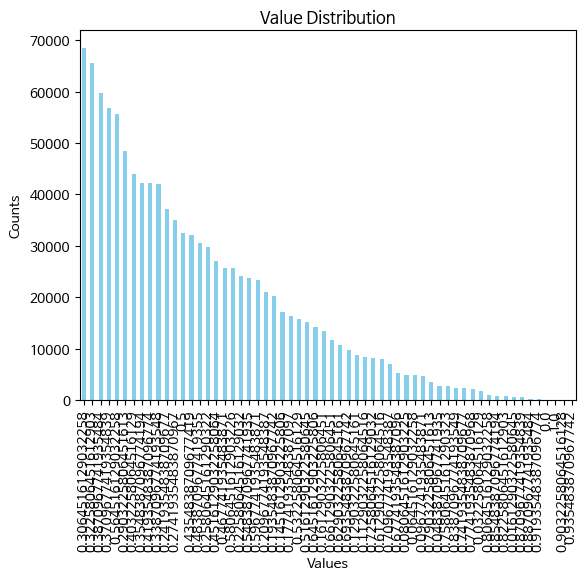

In [24]:
# 값의 분포 계산
value_counts = dt['건축년도'].value_counts()

# 막대그래프 생성
value_counts.plot(kind='bar', color='skyblue')

# 그래프에 제목과 축 라벨 추가
plt.title('Value Distribution')
plt.xlabel('Values')
plt.ylabel('Counts')

# 그래프 출력
plt.show()